<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-the-data" data-toc-modified-id="Read-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read the data</a></span></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train/Test Split</a></span></li><li><span><a href="#Compute-the-RFM-Matrix" data-toc-modified-id="Compute-the-RFM-Matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compute the RFM Matrix</a></span></li><li><span><a href="#Train-the--Pareto/NBD-Model-over-the-training-period." data-toc-modified-id="Train-the--Pareto/NBD-Model-over-the-training-period.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train the  Pareto/NBD Model over the training period.</a></span><ul class="toc-item"><li><span><a href="#Population-parameters" data-toc-modified-id="Population-parameters-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Population parameters</a></span></li><li><span><a href="#Customer-level-parameters" data-toc-modified-id="Customer-level-parameters-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Customer-level parameters</a></span></li><li><span><a href="#Comparisons-Between-Model-Predictions-and-Training-Set-Observations" data-toc-modified-id="Comparisons-Between-Model-Predictions-and-Training-Set-Observations-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Comparisons Between Model Predictions and Training Set Observations</a></span><ul class="toc-item"><li><span><a href="#Scatter-Plot-of-the-Purchase-Counts-:-Observations-vs-Predictions" data-toc-modified-id="Scatter-Plot-of-the-Purchase-Counts-:-Observations-vs-Predictions-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Scatter Plot of the Purchase Counts : Observations vs Predictions</a></span></li></ul></li><li><span><a href="#Comparisons-Between-Predictions-and-the-Holdout-(validation)-Set-Observations" data-toc-modified-id="Comparisons-Between-Predictions-and-the-Holdout-(validation)-Set-Observations-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Comparisons Between Predictions and the Holdout (validation) Set Observations</a></span></li></ul></li><li><span><a href="#Training-a-simple-Gamma-Gamma-model-on-the-monetary-value" data-toc-modified-id="Training-a-simple-Gamma-Gamma-model-on-the-monetary-value-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training a simple Gamma-Gamma model on the monetary value</a></span></li><li><span><a href="#Comparisons-between-E(M)-and-observed-mean-in-training-period" data-toc-modified-id="Comparisons-between-E(M)-and-observed-mean-in-training-period-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Comparisons between E(M) and observed mean in training period</a></span></li><li><span><a href="#Comparisons-between-E(M)-and-observed-mean-in-holdout/validation-period" data-toc-modified-id="Comparisons-between-E(M)-and-observed-mean-in-holdout/validation-period-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparisons between E(M) and observed mean in holdout/validation period</a></span></li><li><span><a href="#Computing-Interpurchase-Time-(IPT)" data-toc-modified-id="Computing-Interpurchase-Time-(IPT)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Computing Interpurchase Time (IPT)</a></span></li><li><span><a href="#Distribution-of-IPT" data-toc-modified-id="Distribution-of-IPT-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Distribution of IPT</a></span></li><li><span><a href="#Distribution-of-Number-of-Purchases-Per-Customer" data-toc-modified-id="Distribution-of-Number-of-Purchases-Per-Customer-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Distribution of Number of Purchases Per Customer</a></span></li></ul></div>

# Predictive Modeling for Customer Lifetime Value (CLV)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Package Installs and Imports

In [2]:
# General Imports
import gc
import os 
import sys 
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import dill
from datetime import datetime 
from hashlib import md5
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from re import sub
import tarfile
from __future__ import division
import seaborn as sns

#Let's make this notebook reproducible 
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [3]:
# Helper functions to fetch files and do some plotting
from s3_helpers import functions as shf
from plotting_helpers import functions as phf

In [4]:
# # Make the default figures a bit bigger
# plt.rcParams['figure.figsize'] = (7,4.5) 
# plt.rcParams["figure.dpi"] = 140 

# sns.set(style="ticks")
# sns.set_context("poster", font_scale = .7, rc={"grid.linewidth": 5})

In [5]:
flaconi = ['#DE9D8F','#BAD1CD', '#F1C2B4', '#4C4C4C', '#C6E0D4', '#D5D5D5']#, '#F6F6F6', '#83132B']
greek_salad = ['#D0D3C5', '#56B1BF', '#08708A', '#D73A31', '#032B2F']
sns.set_palette(greek_salad)
#sns.palplot(sns.color_palette())

# Markov Chain Monte Carlo (MCMC)

MCMC is simply a method to fit a distribution via simulation.  

**Our goal is to infer or fit a set of parameters, $\theta$ of our model.  We first define a prior distribution for $\theta$ (e.g. our belief about $\theta$ before seeing our data), and then update that prior with our observed data using Bayes Theorem (see Eqn. below) to compute a posterior distribution for $\theta$.  The posterior is our belief about $\theta$ after observing the data we wish to fit, and can be thought of as the $\theta$ 'fitted' to (or inferred from) our data.**

$$P(\theta|Data) = \frac{P(Data|\theta)P(\theta)}{P(Data)}$$

**The problem is that often times it's impossible or difficult to compute this posterior distribution analytically.**  
**One way is to draw samples from the posterior distribution for $\theta$.**  

**A *Markov Chain* can be used to allow you to repeatedly randomly sample from the posterior even though we don't yet know what that distribution.  Broadly speaking, in the context of an MCMC simulation, a Markov chain is a process that tells with what probability to draw samples of each possible value for $\theta$ given the last sample drawn.**

We'll be using the No U-Turn Sampler (NUTS) algorithm to accomplish this.

# Training Pareto/NBD and Gamma/Gamma Models

To train the models, we can use either Maximum Likelihood Estimation (**MLE**) or Markov Chain Monte Carlo (**MCMC**) methods. Each method has strengths and weaknesses.

* MCMC is more flexible and allows better tuning of the model.  It also allows us to use prior distributions in order to bring in domain-specific knowledge we may have or knowledge from different data sets.

* MCMC is a numerical simulation method and doesn't require derivation of the analytic form of the model.  Therefore, it's easier to set up so long as we can specify the distributions we wish to fit.  

* MCMC can handle models that may not have analytic forms at all.

* MLE is much faster.  MCMC can take hours or even days depending on the model and data.  MLE takes a few seconds.

* MLE has fewer knobs for tuning the model, and while this makes it inflexible it also means there's less things to worry about when setting it up.  

## Read the data

In [6]:
transactions = pd.read_csv('data/cdnow_transaction_log.csv')
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions[transactions['sales']!=0]

In [7]:
transactions.head()

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


The dataset spans 1.5 year of data. A natural breakdown would be to train on one year of data and validate on the following 6 months. 

## Train/Test Split

In [8]:
# Select training and holdout periods 
# Lets select a training period of one year and and a holdout period of 6 months. 

end_training_time = pd.to_datetime('1997-12-31') # this date is 1 year after first purchase
train = transactions[transactions.date <= end_training_time]
holdout = transactions[transactions.date > end_training_time]


##  Compute the RFM Matrix 

This is the form in which our model will consume the data

In [9]:
def compute_rfm(transactions, end_training_time):
    
    def get_single_cust_rfm(transactions):

        # Compute monetary value, the average value
        # of all of a customer's transactions
        monetary_value = transactions['sales'].mean()

        # Compute the difference between the last day 
        # in the data and a customer's first purchase day
        T = (end_training_time - transactions['date'].min()).days

        # Compute Recency, the difference between a customer's
        # last and first purchase day
        recency = (transactions['date'].max() - transactions['date'].min()).days

        # Compute repeat frequency, the total number of
        # a customer's purchases - 1
        # We can count the number of transactions for a customer
        # by counting the number of rows in 'transactions'
        frequency = len(transactions)-1

        return {'recency': recency, 'frequency': frequency, 
                'monetary_value': monetary_value, 'T': T}


    # get the unique customer IDs
    unique_customers = np.unique(transactions['cust'])
    
    # Initialize RFM dataframe
    rfm = pd.DataFrame(index=range(0, len(unique_customers)), 
                       columns = ['cust', 'recency', 'frequency', 'T', 'monetary_value'],
                       dtype = np.float64)

    # Compute the RFM for each customer and add it to the RFM dataframe
    for ci, cust in enumerate(unique_customers):

        c_idx = np.where(transactions['cust']==cust)[0]
        rfm.iloc[ci] = get_single_cust_rfm(transactions.iloc[c_idx])

    # Add the customer IDs to the RFM dataframe
    rfm['cust'] = unique_customers
    
    return rfm

In [10]:
#Let's compute the RFM dataframe
rfm = compute_rfm(train, end_training_time)

In [11]:
rfm.shape

(2349, 5)

In [12]:
rfm.head()

,cust,recency,frequency,T,monetary_value
0,4,328.0,2.0,347.0,23.723333
1,18,0.0,0.0,361.0,14.960000
2,21,12.0,1.0,364.0,37.555000
3,50,0.0,0.0,364.0,6.790000
4,60,0.0,0.0,333.0,21.750000


In [13]:
# Let's look at the range of values for each column. Make sure the results make sense 
# before going any further with the analysis. No NaNs, 
# no negative values, no recency > 364 days, etc.  

#rfm.describe()

## Train the  Pareto/NBD Model over the training period. 

The individual-level likelihood function of the Pareto/NBD model can be easily derived (e.g. Schmittlein et al. 1987; Fader et al. 2005) and will be used in the code below :
$$L(\lambda, \mu | x, t_x, T) = \frac{\lambda^x \mu}{\lambda+\mu}e^{-(\lambda+\mu)t_x}+\frac{\lambda^{x+1}}{\lambda+\mu}e^{-(\lambda+\mu)T} \tag{1}$$



In [14]:
import pymc3 as pm

In [15]:
# Define a custom likelihood function 
class PNBD(pm.Continuous):
    
    #Pareto/NDB has parameters mu and lambda
    def __init__(self, mu, la, *args, **kwargs):
        super(PNBD, self).__init__(*args, **kwargs)
        self.mu = mu
        self.la = la

    # Special function name logp is recognized by pymc3
    # as the log likelihood of the distribution
    # See Equation 1 above
    def logp(self, obs_freq, obs_rec, obs_T):
        
        # The two terms of the log of likelihood we described previously
        like1 = np.multiply(obs_freq, np.log(self.la)) + np.log(self.mu) - np.log(self.mu+self.la) - np.multiply(obs_rec, (self.mu+self.la))
        like2 = np.multiply((obs_freq + 1), np.log(self.la)) - np.log(self.mu+self.la) - np.multiply(obs_T, (self.la+self.mu))

        return np.log(np.exp(like1) + np.exp(like2))

$\lambda$ is the count rate that goes in the Poisson distribution and $\mu$ is the slope of the lifetime exponential distribution. The typical lifetime corresponds to $\sim 1/\mu$. 

The priors for $\lambda$ and $\mu$ are gamma distributed : 
$$g(\lambda|r,\alpha) = \frac{\alpha^r}{\Gamma(r)}\lambda^{r-1}e^{-\lambda \alpha} \tag{2}$$
and 
$$g(\mu|s,\beta) = \frac{\beta^s}{\Gamma(s)}\mu^{s-1}e^{-\mu \beta} \tag{3}$$ 

For each of the four model parameters $(r,\alpha,s,\beta)$, we assign hyperpriors that are normally distributed. 

In [16]:
n_cust = len(rfm) #Store number of customers
with pm.Model() as pareto_nbd:


    # We want r, alpha, s, and beta to have normal priors
    # but values less than 0 aren't valid here, so we define a
    # normal distribution bounded at 0
    BoundedNormal = pm.Bound(pm.Normal, lower=np.array(0))
    
    # Mu and Lambda values > 1 don't make sense in our context,
    # so we'll define a gamma distribution that is bounded at 1
    BoundedGamma = pm.Bound(pm.Gamma, lower=np.array(0), upper=np.array(1))


    #--Global (population) parameters--#
    # Hyperpriors for parameters for the
    # gamma prior distribution of lambda
    # See Equation 2
    r = BoundedNormal('r', mu = 1, sd = 10);
    alpha = BoundedNormal('alpha', mu = 10, sd = 1000);
    
    # Implement hyperpriors for the parameters
    # for the gamma distribution for mu
    s = BoundedNormal('s', mu = 1, sd = 10);
    beta = BoundedNormal('beta', mu = 10, sd = 1000);
   
    #--Customer parameters--#
    # Gamma prior distribution of lambda
    # Note the shape argument - this tells PyMC3 that
    # we want one lambda for each customer
    # Without this argument, a single lambda would be computed
    # for everyone
    la = BoundedGamma('la', 
                      alpha = r,
                      beta = alpha,
                      shape = n_cust
                      );
    
    # Implement the gamma prior distribution for 
    # mu here, with parameters s and beta
    mu = BoundedGamma('mu', 
                      alpha = s,
                      beta = beta,
                      shape = n_cust
                     );
    
    # Pareto / NBD likelihood.  Mu and Lambdas(La) are fitted
    # frequency, recency, and T are observed from the data
    # mu and la parmeters are estimated for each customer
    ylike = PNBD('ylike', mu = mu, la = la, observed = {'obs_freq': rfm['frequency'].values, 
                                                      'obs_rec': rfm['recency'].values, 
                                                      'obs_T': rfm['T'].values}, shape = n_cust) 


In [17]:
burn_in = 2000

In [18]:
%%time
## Read the saved model
with open('models/paretonbd.pkl', 'rb') as f:
    trace = dill.load(f)

CPU times: user 1.39 s, sys: 3.94 s, total: 5.33 s
Wall time: 6.44 s


### Population parameters

Population Parameters:
----------------------
r:		0.544020484308843
alpha:		77.06150998086302
s:		0.5147576303169963
beta:		85.04501717459479


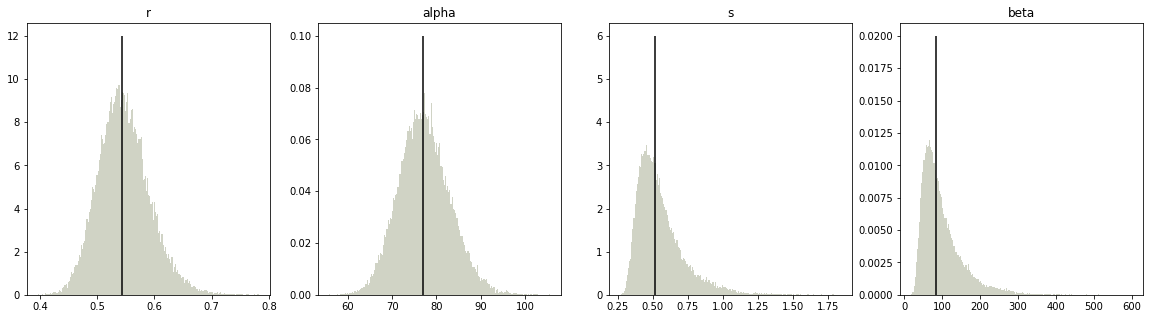

In [19]:
# MCMC methods return distributions of parameters rather than single values
# To get a single estimate we can take the mean, median, or mode
# or some other representative measure from the distribution of that parameter

# Here, we'll use the median to account for some skewness in the distributions

r = np.median(trace[burn_in:].get_values(varname='r'))
alpha = np.median(trace[burn_in:].get_values(varname='alpha'))
s = np.median(trace[burn_in:].get_values(varname='s'))
beta = np.median(trace[burn_in:].get_values(varname='beta'))


# Population level parameter distributions
# and their medians, which we take as the 
# estimated parameter value

plt.rcParams['figure.figsize'] = (20, 5)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.hist(trace[burn_in:].get_values(varname='r'), normed = True, bins = 200);
ax1.set_title('r')
ax1.vlines(r, 0, 12)

ax2.hist(trace[burn_in:].get_values(varname='alpha'), normed = True, bins = 200);
ax2.set_title('alpha')
ax2.vlines(alpha, 0, 0.1)

ax3.hist(trace[burn_in:].get_values(varname='s'), normed = True, bins = 200);
ax3.set_title('s')
ax3.vlines(s, 0, 6)

ax4.hist(trace[burn_in:].get_values(varname='beta'), normed = True, bins = 200);
ax4.set_title('beta')
ax4.vlines(beta, 0, 0.02)

print('Population Parameters:')
print('----------------------')
print('r:\t\t' + str(r))
print('alpha:\t\t' + str(alpha))
print('s:\t\t' + str(s))
print('beta:\t\t' + str(beta))

### Customer-level parameters

Customer-level Parameters (First 5 Customers):
----------------------------------------------


,cust,mu:,la
0,4,0.001271,0.005993
1,18,0.008140,0.003303
2,21,0.009705,0.010725
3,50,0.008169,0.003308
4,60,0.008084,0.003299


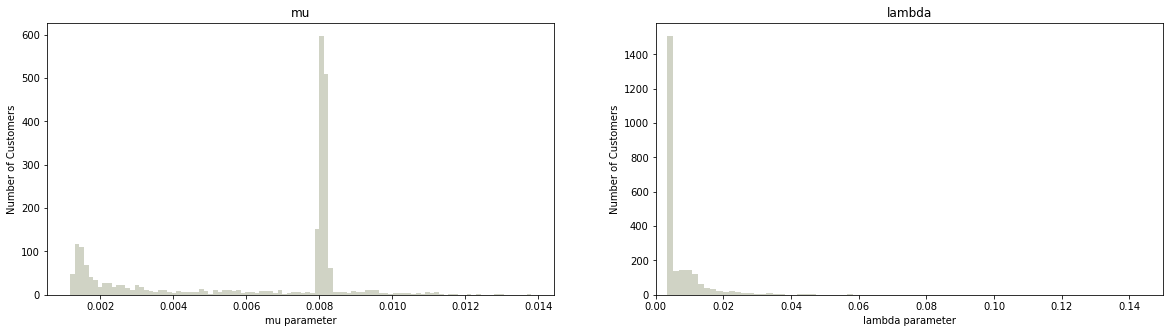

In [20]:
# Customer-level parameters
# Each customer has a unique distribution for mu and lambda
# We'll take the mean of each customer's distribution
# as the estimate of that customer's mu and lambda parameters

# Below we show the distribution of the mu and lambda estimates for all customers
print('Customer-level Parameters (First 5 Customers):')
print('----------------------------------------------')
# Note that we still need to take means
# to get each parameter value, since each
# user has a distribution for each user-specific parameter.

mu_dist = trace[burn_in:].get_values(varname='mu')
la_dist = trace[burn_in:].get_values(varname='la')

mean_mus = mu_dist.mean(axis=0)
mean_las = la_dist.mean(axis=0)
mu_la_df = pd.DataFrame({'cust': rfm['cust'], 
                         'mu:' : mean_mus,
                        'la': mean_las})


f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(trace[burn_in:].get_values(varname='mu').mean(axis = 0), bins = 100);
ax1.set_title('mu')
ax1.set_ylabel('Number of Customers')
ax1.set_xlabel('mu parameter')

ax2.hist(trace[burn_in:].get_values(varname='la').mean(axis = 0), bins = 100);
ax2.set_xlim([0, 0.15])
ax2.set_title('lambda')
ax2.set_ylabel('Number of Customers')
ax2.set_xlabel('lambda parameter')

mu_la_df.head()

### Comparisons Between Model Predictions and Training Set Observations 

The fit above gives us all four model parameters $(r,\alpha,s,\beta)$. Furthermore, the MCMC chain also gives us the values of $\lambda,\mu$ for each customer. Given $(\lambda,\mu)$ it becomes relatively easy to derive the expected number of purchases made by each customer in the period $[T,T+t)$ : 
$$ E[Y(t)~|~\lambda, \mu] = \frac{\lambda}{\mu}-\frac{\lambda}{\mu}e^{-\mu t } \tag{4}$$

In the expression above, Y(t) represents the number of (repeat) purchases between 0 and $t$. 

Parameters $\lambda$ and $\mu$ are latent parameters. They are not observed. However, the MCMC sampling technique allows us to extract the joint posterior distribution of $\lambda$ and $\mu$ at the customer level. This is very handy. Indeed, one simply has to evaluate the expression above for all the pairs of $\lambda$ and $\mu$ included in the MCMC trace. 

When making predictions about purchase count in the training period we also need to compute the probability of a customer being alive.  After all, a churned customer won't make any purchases.  To compute that probability we can use the following equation:

$$P(\tau > T|\lambda, \mu, x, t_x, T) = \frac{1}{1+\mu/(\mu+\lambda)[e^{(\lambda + \mu)(T-t_x)}-1]}$$

Then, to compute the expected purchase count we use:

$$ E[Y(t)~|~\lambda, \mu] \cdot P(\tau > T|\lambda, \mu, x, t_x, T)$$

Note that for the training period we assume that this probability is equal to 1 (the customer has not churned in this period) and so in that case we can just use Equation 4, but for the validation period we need the full equation shown above.

#### Scatter Plot of the Purchase Counts : Observations vs Predictions 

In [21]:
# The training time in days
dt_train = end_training_time.to_period('D') - transactions['date'].min().to_period('D') 

#From equation 4
training_predictions = (la_dist/mu_dist-la_dist/mu_dist*np.exp(-mu_dist*dt_train)).mean(axis=0)

rfm['model_train_frequency'] = training_predictions


RMSE = 0.7680102641595149


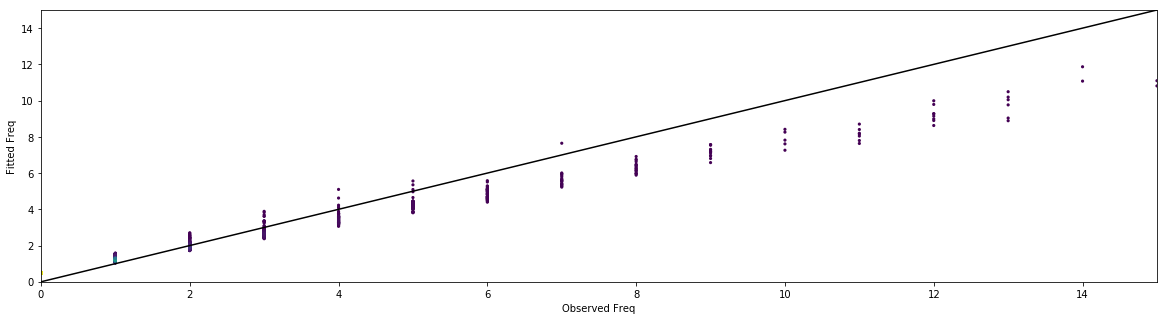

In [22]:
# Compute RMSE in the training data
rmse_train_count = (rfm['model_train_frequency'] - rfm['frequency']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(rfm))
print('RMSE =', rmse_train_count)

# Let's see the scatter plot predicted vs observed purchase counts in the training period. 

phf.plot_scatter(rfm, 'frequency', 'model_train_frequency', 
             xlabel='Observed Freq', ylabel = 'Fitted Freq')

Not bad. The model is underestimating the frequency, but generally produces reasonable predictions.  Though this is expected given that this dataset was used to train the model. A more meaningful comparison would be done on a holdout period that the model has not seen yet. That's what we'll do below. 

I recommend adding to the diagnostics scatter plot above. A few suggestions include : 
* A chart showing the residuals per observed counts. This may indicate where the model performs poorly. 
* A cumulative distribution function (CDF) of the total number of purchases. This will be useful to determine whether or not the model can be used to forecast demand for this particular cohort of customers 

### Comparisons Between Predictions and the Holdout (validation) Set Observations

As discussed below, we will now take a look at the holdout period. 

In [23]:
def prob_alive_at_T(la, mu, t_x, T): 
    """Computes the probability of being alive at T given lambda, mu, t_x, and T"""
    return 1. / ( 1. + mu / (mu + la) * (np.exp((la + mu) * (T - t_x)) - 1.) )

In [24]:
mu_dist = mean_mus
la_dist = mean_las

# Get length of holdout prediction period in terms of model period
dt_holdout = transactions['date'].max().to_period('D') - end_training_time.to_period('D')

T_values = np.tile(rfm['T'].values, [len(trace) - burn_in, 1])
recency_values = np.tile(rfm['recency'].values, [len(trace) - burn_in, 1])

# Holdout counts predictions - note we have a probability to be alive in this case: 
holdout_predictions = ((la_dist/mu_dist-la_dist/mu_dist*np.exp(-mu_dist*dt_holdout))*\
                        prob_alive_at_T(la_dist, mu_dist, recency_values, T_values)).mean(axis=0)

rfm['frequency_predicted'] = holdout_predictions 

In [25]:
# lets look at the observed number of transactions during the same time period : 
# counts per customer per date : 
holdout_counts = holdout.groupby(['cust', 'date'], as_index=False).size().reset_index()

# counts per customer
# note that the holdout counts are also the frequency
# because the 'first' purchase is not included in the holdout counts
holdout_counts = holdout_counts.groupby(['cust']).size() 

# Let's merge with the rfm dataframe. 
rfm.drop(['obs_holdout_frequency'], inplace = True, errors = 'ignore', axis=1) # Remove this column if it already exists
rfm = rfm.merge(pd.DataFrame(holdout_counts), how='left', left_on='cust', right_index = True)
rfm.rename(columns={0:'obs_holdout_frequency'}, inplace=True)
rfm.fillna(0, inplace=True)

RMSE = 1.0561572294685955


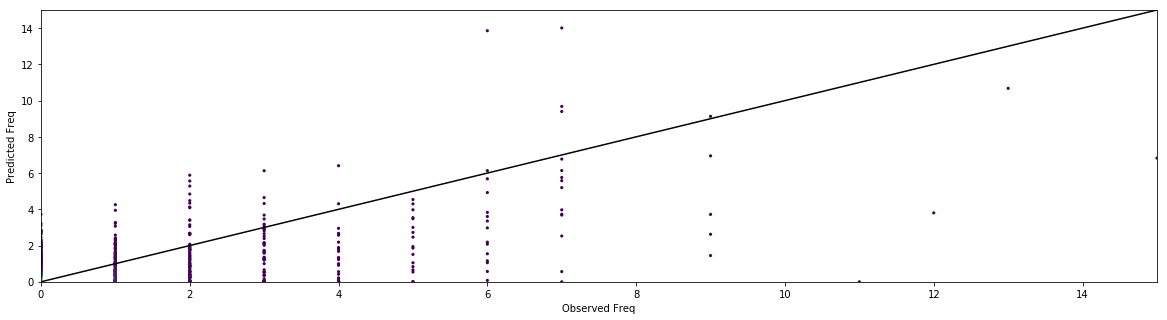

In [26]:
# Let's now plot the data : 
# NOTE:  Here we compare frequency to 'count' 
rmse_holdout_count=(rfm['frequency_predicted']-rfm['obs_holdout_frequency']).apply(lambda x :x*x)
rmse_holdout_count=np.sqrt(rmse_holdout_count.sum()/len(rfm))
print('RMSE =',rmse_holdout_count)
phf.plot_scatter(rfm, 'obs_holdout_frequency', 'frequency_predicted',
            xlabel='Observed Freq', ylabel = 'Predicted Freq')

Not surprisingly we're not doing as well on the holdout set than we did on the training set.

There are several ways to improve the holdout results. Segmentation is one of them. 

In [27]:
del trace, la_dist, mu_dist, T_values, recency_values
gc.collect();

## Training a simple Gamma-Gamma model on the monetary value 

The next steps is to look at the monetary value model. This model follows closely the Gamma-Gamma model discussed in Fader et al. (2004). Note that the monetary value component is generally very difficult to model. Many factors can affect the price of items in ways that are not accounted for by the model. Long term changes in prices over several years (akin to inflation), discounts, promotions, etc. are difficult to capture in this and other simple monetary value models. That is something to keep in mind when doing comparisons over the holdout period and making predictions for future purchases. 

In the gamma model, the observed average order value in the training period is an imperfect metric of the latent mean transaction value $E(M)$ at the customer level. 

The main assumption behind the gamma model is that the average order value at the customer level is distributed according to a gamma distribution of shape $p$ and scale $\nu$ 
$$ p(m_x~|~p, \nu, x) = \frac{(\nu x)^{px}m_x^{px-1}e^{-\nu x m_x}}{\Gamma(px)} \tag{5}$$

where 
* $x$ is the total number of transactions (`rfm['frequency']+1`) 
* $m_x$ is the average order value
* $p$ is the shape parameter of the gamma distribution. The model assumes that this parameter is the same for all customers. 
* $\nu$ is the rate parameter of the gamma distribution. $\nu$ varies across customers and has a prior that is also gamma distributed with parameters $(q,\gamma)$

The prior for $\nu$ is given by:

$$g(\nu|q,\gamma) = \frac{\gamma^q}{\Gamma(q)}\nu^{q-1}e^{-\nu \gamma} \tag{6}$$ 


In [28]:
n_cust = len(rfm)

with pm.Model() as gamma_gamma:
    
    #Define a bounded normal distribution
    BoundedNormal = pm.Bound(pm.Normal, lower=np.array(0))
    
    p = BoundedNormal('p', mu = 10, sd = 100)    # prior distribution on p
    q = BoundedNormal('q', mu = 10, sd = 100)    # hyperprior distribution on q 
    y = BoundedNormal('y', mu = 10, sd = 100)    # hyperprior distribution on y

    # Implement the distribution for v as in Equation 6 and similar
    # to the distributions on mu and lambda in the Pareto/NBD model
    v = pm.Gamma('v', alpha = q, beta = y, shape = n_cust)
        
    # Here we multiply p * count.  the Deterministic() class allows us to make
    # non-stochastic computations like these
    px = pm.Deterministic('px', p * (rfm['frequency'].values + 1.0))
    
    # Compute v * x
    nx = pm.Deterministic('nx', v * (rfm['frequency'].values + 1.0))

    # Gamma likelihood as shown in Equation 5
    mx = pm.Gamma('mx', alpha = px, beta = nx, observed = rfm['monetary_value'].values, shape = n_cust)

In [29]:
burn_in = 5000

In [30]:
with open('models/gamma_gamma.pkl', 'rb') as f:
    trace_gg = dill.load(f)

Population Parameters:
----------------------
p:		8.035707457901829
q:		3.558452525017554
y:		10.47151543310214


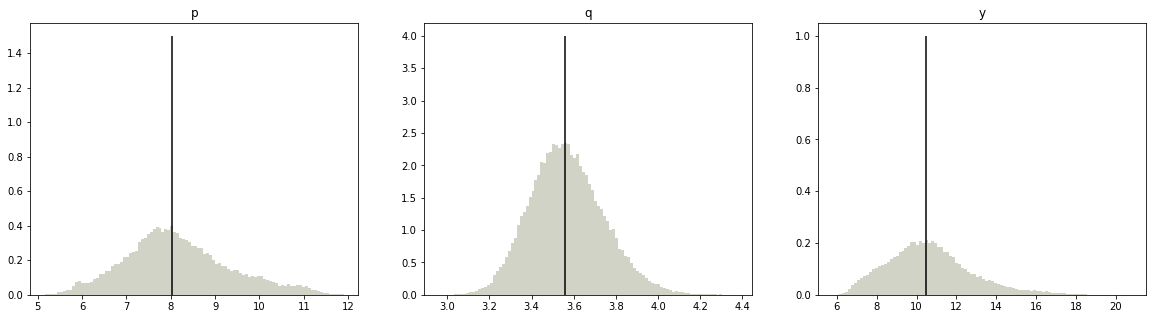

In [31]:
print('Population Parameters:')
print('----------------------')
p = np.median(trace_gg[burn_in:].get_values(varname='p'))
print('p:\t\t' + str(p))
q = np.median(trace_gg[burn_in:].get_values(varname='q'))
print('q:\t\t' + str(q))
y = np.median(trace_gg[burn_in:].get_values(varname='y'))
print('y:\t\t' + str(y))

f, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.hist(trace_gg[burn_in:].get_values(varname='p'), normed = True, bins = 100);
ax1.set_title('p')
ax1.vlines(p, 0, 1.5)

ax2.hist(trace_gg[burn_in:].get_values(varname='q'), normed = True, bins = 100);
ax2.set_title('q')
ax2.vlines(q, 0, 4)

ax3.hist(trace_gg[burn_in:].get_values(varname='y'), normed = True, bins = 100);
ax3.set_title('y')
ax3.vlines(y, 0, 1);

Customer-level Parameters:
--------------------------


,cust,v:,px:,nx:
0,4,0.344003,24.472985,1.032010
1,18,0.464026,8.157662,0.464026
2,21,0.232727,16.315323,0.465454
3,50,0.689243,8.157662,0.689243
4,60,0.365551,8.157662,0.365551


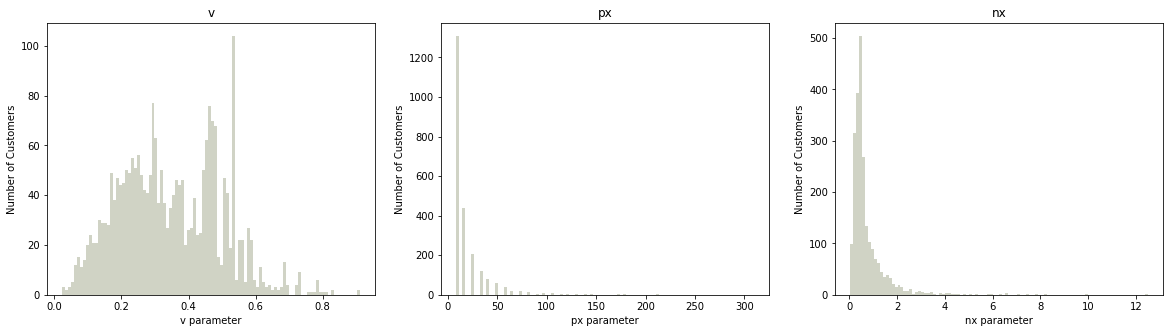

In [32]:
print('Customer-level Parameters:')
print('--------------------------')
# Note that we still need to take means
# to get each parameter value, since each
# user has a distribution for each user-specific parameter.

p_dist = trace_gg[burn_in:].get_values(varname='p')
v_dist = trace_gg[burn_in:].get_values(varname='v')

gg_indiv_df = pd.DataFrame({'cust': rfm['cust'], 
                         'v:' : trace_gg[burn_in:].get_values(varname='v').mean(axis=0),
                        'px:' : trace_gg[burn_in:].get_values(varname='px').mean(axis=0),
                        'nx:' : trace_gg[burn_in:].get_values(varname='nx').mean(axis=0)})


# Customer-level parameters
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(trace_gg[burn_in:].get_values(varname='v').mean(axis = 0), bins = 100);
ax1.set_title('v')
ax1.set_ylabel('Number of Customers')
ax1.set_xlabel('v parameter')

ax2.hist(trace_gg[burn_in:].get_values(varname='px').mean(axis = 0), bins = 100);
ax2.set_title('px')
ax2.set_ylabel('Number of Customers')
ax2.set_xlabel('px parameter')

ax3.hist(trace_gg[burn_in:].get_values(varname='nx').mean(axis = 0), bins = 100);
ax3.set_title('nx')
ax3.set_ylabel('Number of Customers')
ax3.set_xlabel('nx parameter')

gg_indiv_df.head()

# Computing E(M)

Ultimately, this model will give us the expected average transaction value for a customer with an average spend of $m_x$ dolalrs across $x$ transactions in the training period. In this case, the expectation value of the gamma distribution, which is the mean purchase value is:

$$E(M) = p/\nu \tag{7}$$

The MCMC sampling technique gives us the posterior distribution of $\nu$. To get an estimate of $E(M)$ at the customer level, one simply has to average the value of $p/\nu$ over the MCMC trace values of $\nu$ and $p$, at the customer level. We go over the steps in the cells below. 


$E(M)$ will then be multiplied by $E[Y(t)~|~\lambda, \mu, \rm{alive~at~T}]$ to give us the CLV of each customer in the holdout period. 

In [33]:
E_M = (p_dist / v_dist.T).mean(axis=1)

rfm.drop(['monetary_value_predicted'], inplace = True, errors = 'ignore', axis=1) # Remove this column if it already exists
rfm = rfm.merge(pd.DataFrame(E_M), how='left', left_index=True, right_index=True)
rfm.rename(columns={0:'monetary_value_predicted'}, inplace=True)

## Comparisons between E(M) and observed mean in training period 

In [34]:
rfm[['monetary_value', 'monetary_value_predicted']].head()

,monetary_value,monetary_value_predicted
0,23.723333,24.601585
1,14.960000,19.331279
2,37.555000,36.894948
3,6.790000,13.119508
4,21.750000,24.437845


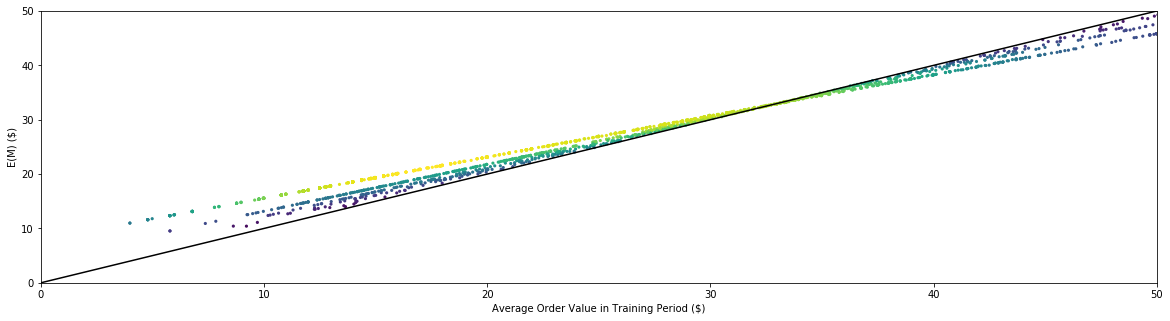

In [35]:
# Let's explore the results : 

phf.plot_scatter(rfm,'monetary_value','monetary_value_predicted', 
             xlabel='Average Order Value in Training Period ($)', 
             ylabel='E(M) ($)', 
             xlim=[0,50], ylim=[0,50])

In the figure above, what can be perceived as different "lines" correspond to different values of "x". 

## Comparisons between E(M) and observed mean in holdout/validation period 

In [36]:
# Let's compute the observed mean transaction value per customer in the holdout period : 

holdout_value = holdout.groupby(['cust', 'date'], as_index=False)['sales'].sum().reset_index()
holdout_value = holdout_value[['cust', 'sales']].groupby(['cust'], as_index = False)['sales'].mean()
holdout_value=pd.DataFrame(holdout_value)
holdout_value.rename(columns={'sales':'obs_holdout_monetary_value'}, inplace=True)

# merge with rfm dataframe : 
rfm.drop(['obs_holdout_monetary_value'], inplace = True, errors = 'ignore', axis=1) # Remove this column if it already exists
rfm = rfm.merge(holdout_value, how='left', left_on='cust', right_on='cust')
rfm.fillna(0,inplace=True)

# Note that we don't need to compute an E(M) for the holdout period
# Predicted E(M) is the same for all time periods because it's a customer's
# expected average order values for all orders, ever

In [37]:
rfm[['obs_holdout_monetary_value', 'monetary_value_predicted']].head()

,obs_holdout_monetary_value,monetary_value_predicted
0,0.0,24.601585
1,0.0,19.331279
2,0.0,36.894948
3,0.0,13.119508
4,0.0,24.437845


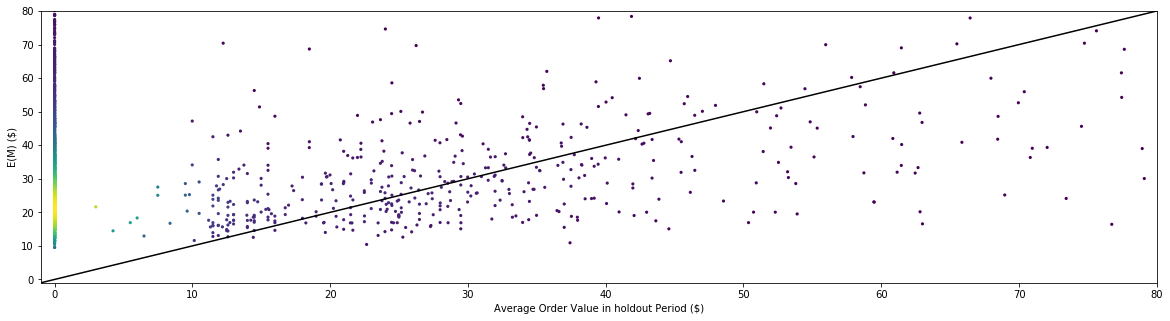

In [38]:
phf.plot_scatter(rfm,'obs_holdout_monetary_value','monetary_value_predicted', 
             xlabel='Average Order Value in holdout Period ($)', 
             ylabel='E(M) ($)', 
             xlim=[-1,80], ylim=[-1,80])

This chart above highlights how difficult it is to accurately model the monetary value. Most of the data points are found along the observed value of 0. This is because most customers did not make a purchase in the holdout period. For the ones who did, the scatter is very large. The model tends to overestimate the monetary value in the holdout period. 

# Finally, computing the CLV in the holdout period and comparing with with model predictions 

We are at the end of this exercise. The last step is to compute the customer-level CLV predictions for the holdout period. I invite you to do the same comparison for the training period. 

CLV is obtained by 
$$CLV(T,T+t) = E(M)~\times~ E[Y(t)~|~\lambda, \mu, \rm{alive~at~T}] \tag{8}$$

In [39]:
# compute both modeled and observed CLV in the holdout period : 

# The model-predicted CLV
rfm['model_holdout_clv'] = rfm['frequency_predicted'] * rfm['monetary_value_predicted']

# Compute the observed CLV
rfm['obs_holdout_clv'] = rfm['obs_holdout_frequency'] * rfm['obs_holdout_monetary_value']


rmse_holdout_clv = (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])* \
                   (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])
rmse_holdout_clv = np.sqrt(rmse_holdout_clv.sum()/len(rfm))

RMSE = 47.33667573643691


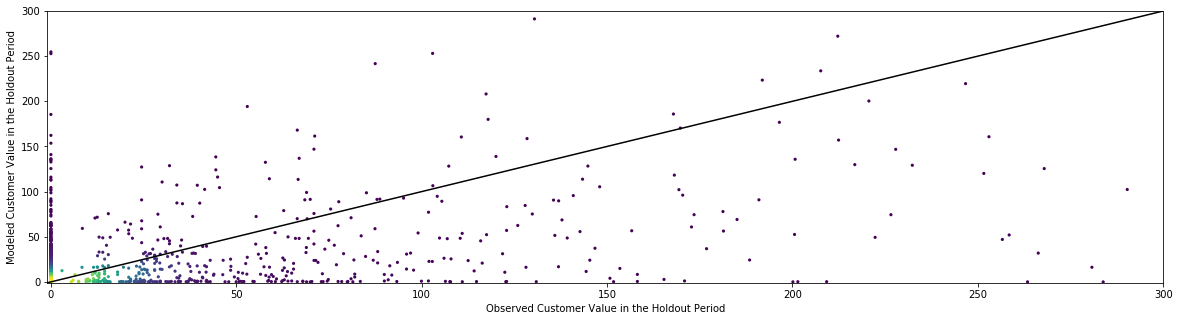

In [40]:
# plot the final results : 
print('RMSE =', rmse_holdout_clv)
phf.plot_scatter(rfm, 'obs_holdout_clv', 'model_holdout_clv',
             xlabel='Observed Customer Value in the Holdout Period',
             ylabel='Modeled Customer Value in the Holdout Period', 
             xlim=[-1,300.0],ylim=[-1,300.0])

# DS_CLV Module

In [41]:
def s3_fetch_module(s3_path, file_name, use_creds = True):
    
    """

    Fetch a module in a tar.gz file from s3
    
    """
    
    s3, bucket = get_s3_client(use_creds = use_creds)
    print('Fetching ' + s3_path + file_name)
    s3.download_file(Bucket=bucket, Key=s3_path + file_name, Filename=file_name)

                
    dir_name = sub('.tar.gz$', '', file_name)
    
    contains_hyphen = False
    if '-' in dir_name:
        contains_hyphen = True
        print("Module name contains invalid '-' hyphens.  Replacing with '_' underscores")
        dir_name = dir_name.replace('-','_')
    
    
    try:
        shutil.rmtree('./' + dir_name)
        print('Removing old module ' + dir_name)
    except:
        pass
    
    print('Extracting ' + file_name + ' into ' + dir_name)
    archive = tarfile.open(file_name, 'r:gz')
    archive.extractall('./')
    archive.close()
    
    if contains_hyphen:
        os.rename(dir_name.replace('_','-'), dir_name)
        
    try:
        os.remove(file_name)
        print('Removing ' + file_name)
    except:
        pass
    
    if ~os.path.exists(dir_name + '/__init__.py'):
        print('__init__.py not found.  Creating it in ' + dir_name)
        open(dir_name + '/__init__.py','w').close()


In [42]:
from s3_helpers import functions as shf

In [43]:
from ds_clv.rfm import RFM

In [44]:
# Let's create the RFM dataframe
# We don't need to write a function this time
# The ds_clv package can do this for us

rfm2 = RFM.from_transaction_log(transactions, customer_id_col='cust',
    datetime_col='date', calibration_period_end=end_training_time,
    monetary_value_col='sales', freq='D')

In [45]:
rfm2.rfm.head()

,frequency,recency,T,monetary_value
cust,,,,
4,2.0,328.0,347.0,23.723333
18,0.0,0.0,361.0,14.960000
21,1.0,12.0,364.0,37.555000
50,0.0,0.0,364.0,6.790000
60,0.0,0.0,333.0,21.750000


# In conclusion 

The Pareto/NBD model is a good introduction to CLV modeling. The gamma-gamma model for monetary value is easy and simple to train. 

There are however several limitations to these approaches. More sophisticated models could include user segmentation. Bayes hierarchical models may also be able to better discriminate groups of customers who exhibit different behaviors and model their $\lambda$ and $\mu$ accordingly. 

The team of data scientists at DataScience can help you designing and improve these models. For our DataScience Cloud Platform customers, we provide a CLV playbook along with a library of CLV models, diagnostics and support. 

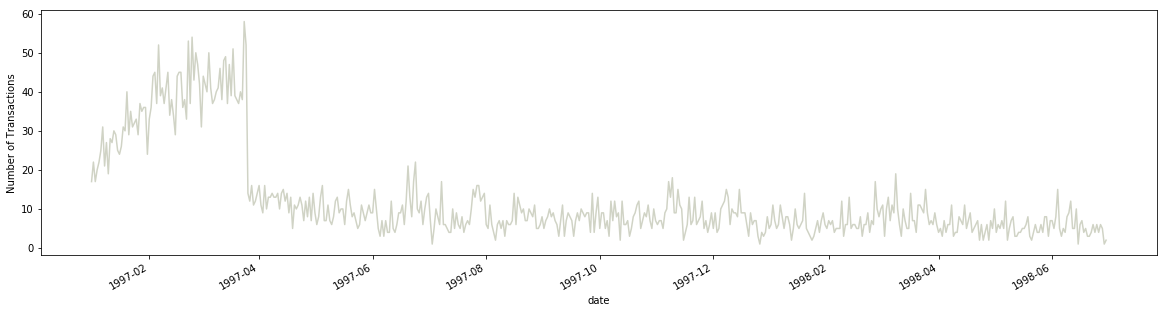

In [46]:
# Time series of the number of transactions (daily) 
plt.rcParams['figure.figsize'] = (20, 5)
ts_transactions = transactions.groupby(['date']).size()
plt.ylabel('Number of Transactions')
ts_transactions.plot();

The chart above looks at the number of transactions per day. As you probably noticed, there is a sharp break in the counts at the end of `1997-03`. That is because the dataset only includes the customers who made their first purchase in the first quarter of 1997. That is, in this data set we are acquiring new customers from 1997-01 until the end of 1997-Q1, and the new customer transactions are included in this period.  But we stop including new customers post 1997-Q1 in the data, so transactions from new customers are no longer included after this date, leading to the discontinuous drop in transaction count.  If the dataset would have also included the customers who made their first purchase post 1997-Q1, the count per day would have likely continued to increase. 

This is a standard practice when modeling CLV. The cohorts of customers used to train the models are generally based on their **time of first purchase**. That way, one can study the evolution of the population parameters over time and pinpoint possible problems in the long run. That is, changes in the business, the product, marketing, etc may change how customer transactions evolve from the time of first purchase onward, and by splitting customers into cohorts based on time of first purchase we can monitor these effects.

The drawback of using such cohort-based approach is that you have fewer datapoints for each cohort. 

## Computing Interpurchase Time (IPT)

 The IPT is useful to look at to determine whether the NBD model should be used

 Let's take a look at the typical IPT and IPT distribution 

 To compute interpurchase time we need to compute the difference 
 between each purchase and the subsequent purchase that follows

 transaction_time_n - transaction_time_(n-1)
 
 We can simply sort by date, then group by the customer ID, and finally compute the difference between each date
 
 We'll finally drop the NaT (Not a Time) values, which are generated for the final purchase of each customer

In [47]:
# Make a copy of the transaction's data frame
transactions_tmp = transactions.copy()

# Compute IPT in days
transactions_tmp['IPT(days)'] = transactions_tmp.sort_values('date', ascending = True).groupby(['cust'], as_index=False)[['date']].diff()

# Drop rows that don't have an IPT (e.g. if it's the last purchase)
transactions_tmp = transactions_tmp[~transactions_tmp['IPT(days)'].isnull()]

# Convert IPT from type timedelta to type integer
transactions_tmp['IPT(days)'] = transactions_tmp['IPT(days)'].apply(lambda l: l.days)

transactions_tmp.head(5)

,cust,date,sales,IPT(days)
1,4,1997-08-02,14.96,196
2,4,1997-12-12,26.48,132
5,21,1997-01-13,11.77,12
11,111,1997-01-11,32.99,10
12,111,1997-03-15,77.96,63


In [48]:
# let's print the mean IPT. Our training period of 365 days is long enough. 

print(transactions_tmp['IPT(days)'].mean())

70.87298294144767


## Distribution of IPT

The IPT distribution can tell us whether the Pareto/NBD model assumptions are being met.  Specifically, we expect that the log density of the IPT distribution should be linear.

(0, 270)

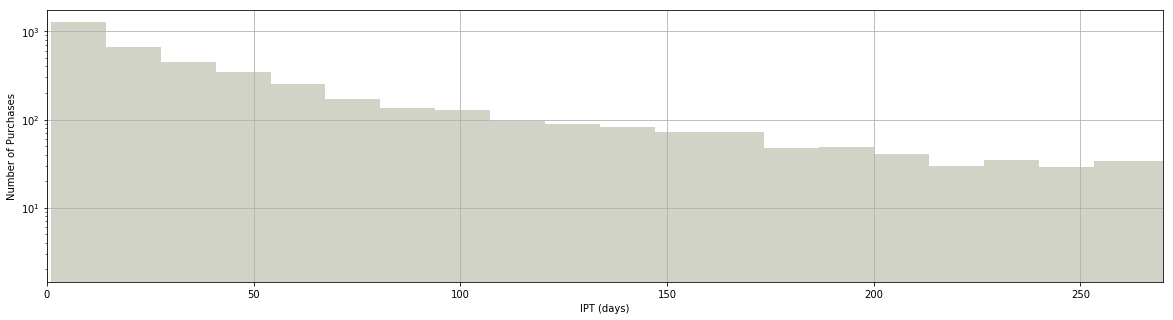

In [49]:
# Distribution of IPT : 

transactions_tmp['IPT(days)'].hist(bins=40)
plt.yscale('log')
plt.xlabel('IPT (days)') 
plt.ylabel('Number of Purchases') 

# 275 (365-90) days to avoid right censorship issues. 
plt.xlim([0,270])

In [50]:
# Compute log density of the interpurchase time
# 
vals, bins = np.histogram(transactions_tmp['IPT(days)'].values, bins=40)
log_density = np.log(vals / vals.sum())
log_density[np.isneginf(log_density)] = 0
bins=bins[:-1]

In [51]:
#Fit a line ot the log density
from scipy.stats import linregress
density_fit = linregress(bins, log_density)
ydens_fit = (bins * density_fit.slope) + density_fit.intercept

Fit R^2: 0.9420827711257937


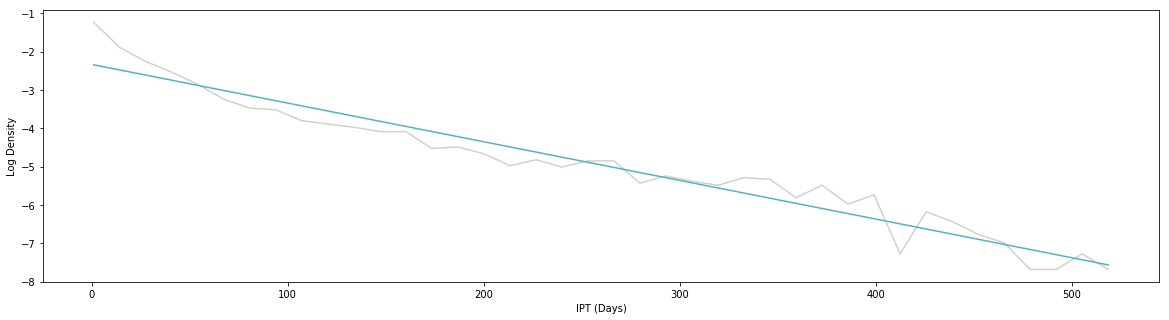

In [52]:
print('Fit R^2: ' + str(density_fit.rvalue**2))
plt.plot(bins, log_density)
plt.plot(bins, ydens_fit)
plt.xlabel('IPT (Days)')
plt.ylabel('Log Density')
plt.show();

## Distribution of Number of Purchases Per Customer

1 44


Text(0,0.5,'Number of Customers')

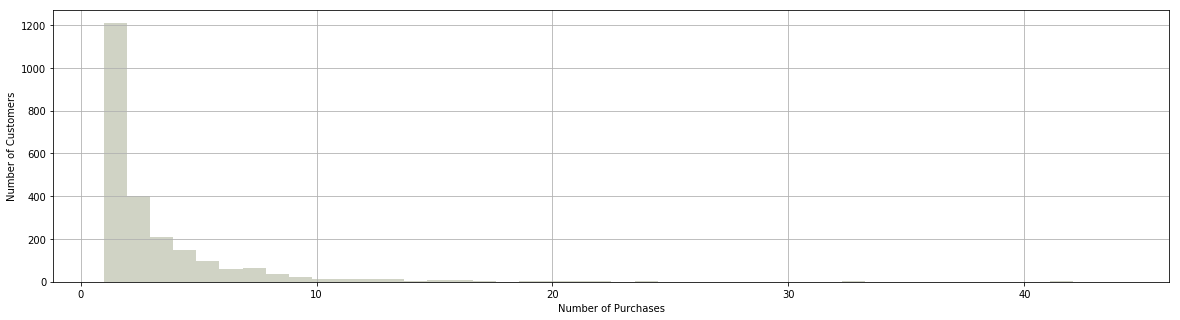

In [53]:
# Let's look at the distribution of the number of purchases per customer : 

n_purchases = transactions.groupby(['cust']).size()
print(n_purchases.min(axis=0), n_purchases.max(axis=0))
n_purchases.hist(bins=(n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1)
plt.xlabel('Number of Purchases') 
plt.ylabel('Number of Customers') 

As we see in the figure above, more than 50% (1200/2357) of the customers made only a single purchase in the 1.5 year period covered by the dataset. 

# END

https://github.com/Cbrands-DSCloud-Pilot/CLV/blob/master/clv-lab-answers.ipynb